In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data
from datetime import datetime
import yfinance as yfin
from pandas_datareader import data as pdr
yfin.pdr_override()

spy = pdr.get_data_yahoo('SPY', start='2021-01-01', end='2024-06-28')
today = datetime(2024, 6, 28)
year_ago = datetime(2021, 1, 1)
company_list = ['VITL', 'USAP', 'BLBD', 'ROAD']
for company in company_list:
    print(company)
    globals()[company] = pdr.get_data_yahoo(company, start= year_ago, end=today)

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed


VITL


[*********************100%%**********************]  1 of 1 completed


USAP


[*********************100%%**********************]  1 of 1 completed


BLBD


[*********************100%%**********************]  1 of 1 completed


ROAD


[*********************100%%**********************]  1 of 1 completed


In [3]:
VITL.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,25.410000,25.440001,24.080000,25.059999,25.059999,384800
2021-01-05,25.290001,25.820000,25.000999,25.629999,25.629999,317100
2021-01-06,26.000000,27.469999,25.500000,26.549999,26.549999,621200
2021-01-07,26.139999,27.650000,25.709999,27.530001,27.530001,365200
2021-01-08,27.520000,28.500000,26.799999,27.160000,27.160000,459400


In [4]:
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    data['EMA12'] = data['Adj Close'].ewm(span=short_window, adjust=False).mean()
    data['EMA26'] = data['Adj Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['Signal Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data

def compute_rsi(data, window=14):
    delta = data['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data

def combine_rsi_macd(data):
    data['Signal'] = 0
    data.loc[(data['MACD'] > data['Signal Line']) & (data['RSI'] < 30), 'Signal'] = 1  
    data.loc[(data['MACD'] < data['Signal Line']) & (data['RSI'] > 70), 'Signal'] = -1 
    return data

In [5]:
stocks = [VITL, USAP, BLBD, ROAD]
stock_names = ['VITL', 'USAP', 'BLBD', 'ROAD']
for stock, name in zip(stocks, stock_names):
    stock = compute_macd(stock)
    stock = compute_rsi(stock)
    stock = combine_rsi_macd(stock)
    globals()[name] = stock

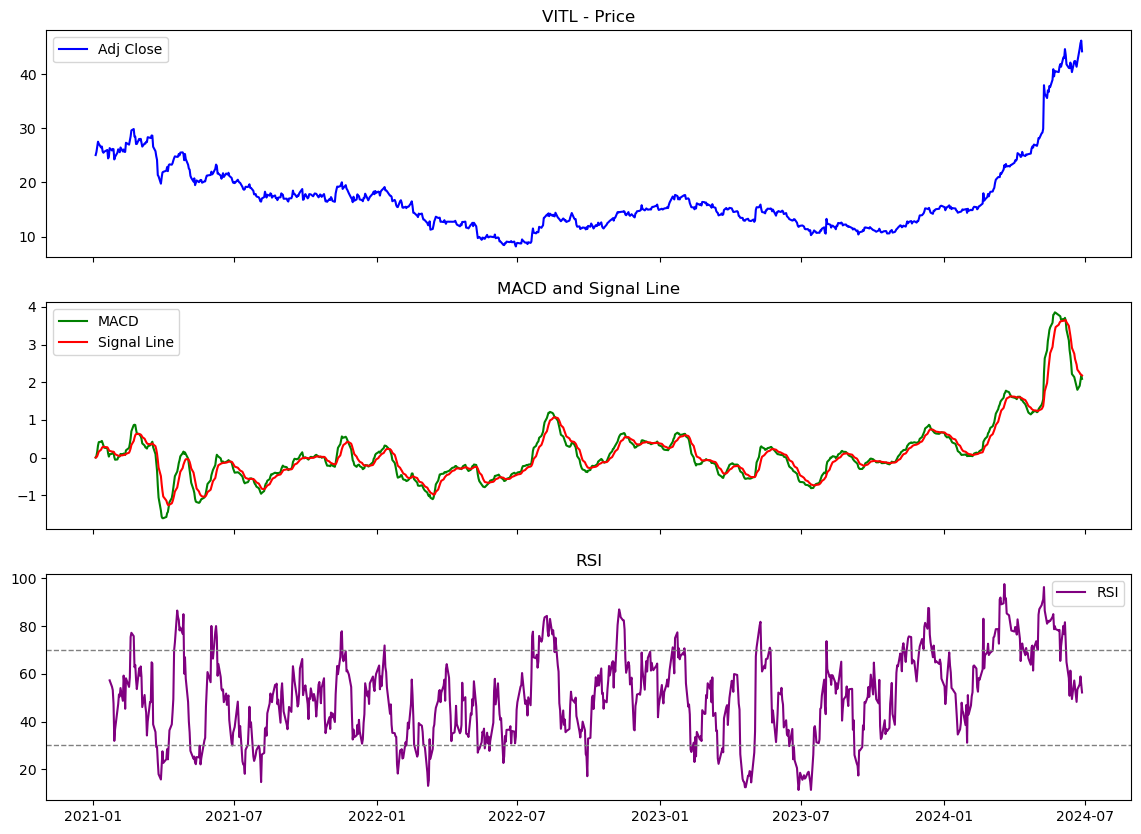

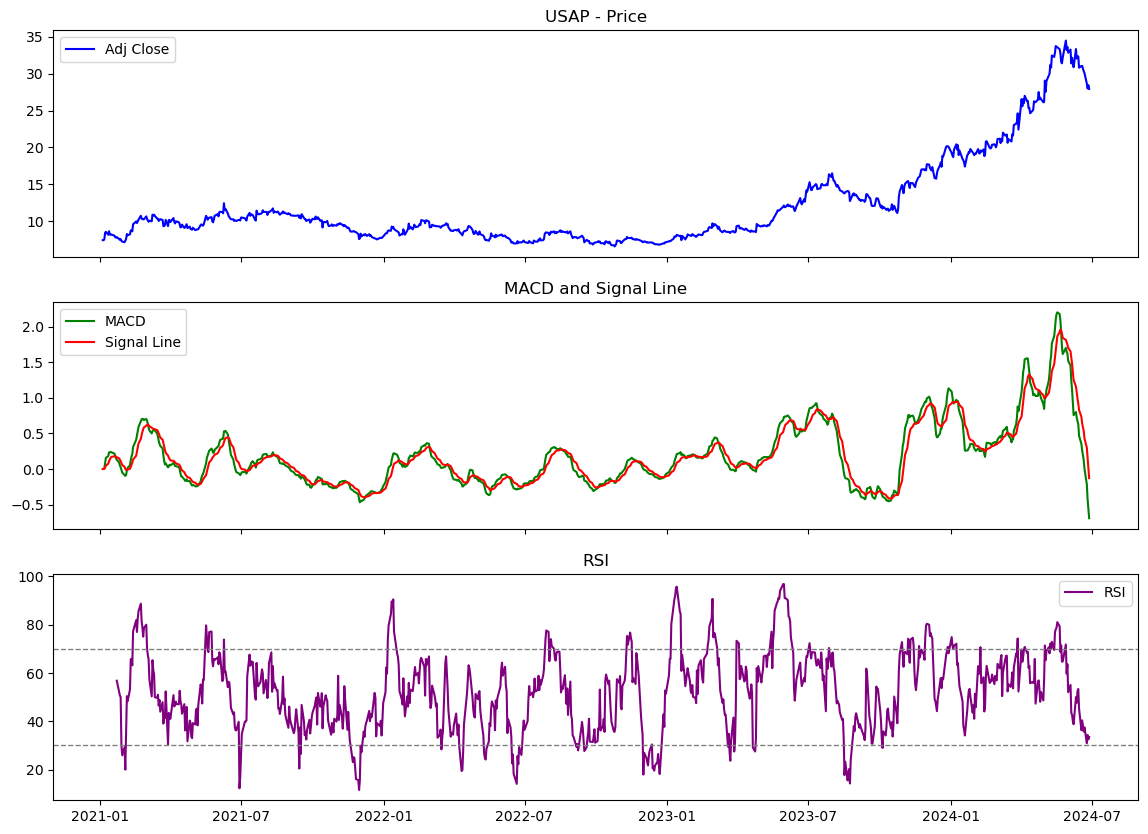

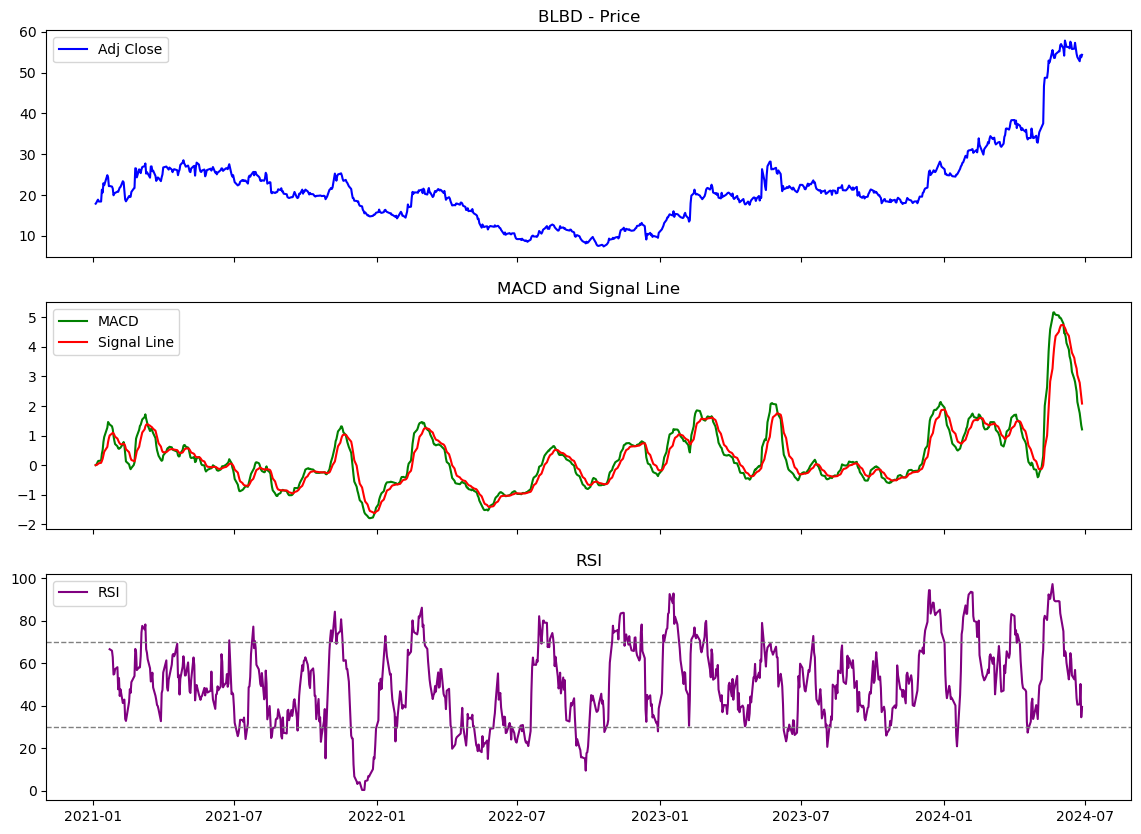

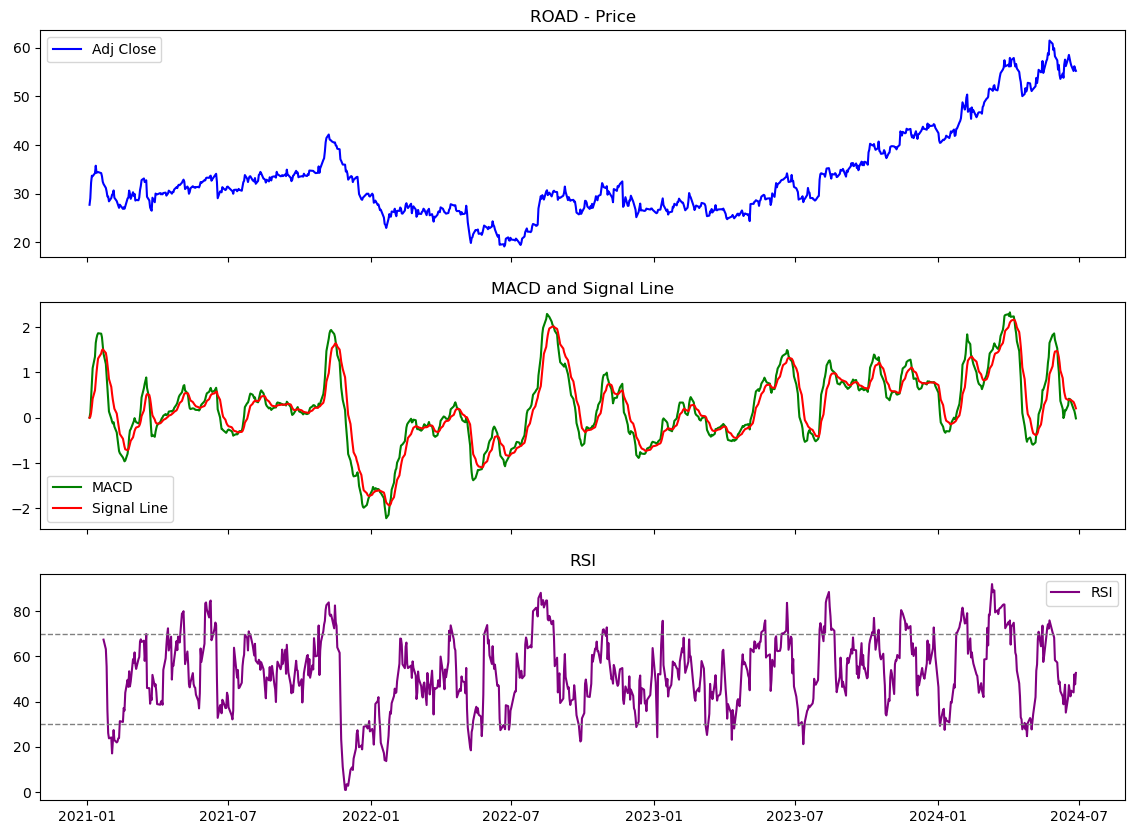

In [6]:
def plot_combined_indicators(data, title):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    ax1.plot(data['Adj Close'], label='Adj Close', color='blue')
    ax1.set_title(f'{title} - Price')
    ax1.legend()
    
    ax2.plot(data['MACD'], label='MACD', color='green')
    ax2.plot(data['Signal Line'], label='Signal Line', color='red')
    ax2.set_title('MACD and Signal Line')
    ax2.legend()
    
    ax3.plot(data['RSI'], label='RSI', color='purple')
    ax3.axhline(30, linestyle='--', linewidth=1, color='grey')
    ax3.axhline(70, linestyle='--', linewidth=1, color='grey')
    ax3.set_title('RSI')
    ax3.legend()
    
    plt.show()

for stock, name in zip(stocks, stock_names):
    plot_combined_indicators(stock, name)

In [7]:
def compute_sma(data, window=50):
    data[f'SMA_{window}'] = data['Adj Close'].rolling(window=window).mean()
    return data

In [8]:
def macd_sma_rsi(data, sma_window=50):
    data['Signal'] = 0
    buy_condition = (data['MACD'] > data['Signal Line']) & (data['RSI'] < 30) & (data['Adj Close'] > data[f'SMA_{sma_window}'])
    sell_condition = (data['MACD'] < data['Signal Line']) & (data['RSI'] > 70) & (data['Adj Close'] < data[f'SMA_{sma_window}'])
    data.loc[buy_condition, 'Signal'] = 1 
    data.loc[sell_condition, 'Signal'] = -1 
    return data

In [9]:
stocks = [VITL, USAP, BLBD, ROAD]
stock_names = ['VITL', 'USAP', 'BLBD', 'ROAD']

for stock, name in zip(stocks, stock_names):
    stock = compute_macd(stock)
    stock = compute_rsi(stock)
    stock = compute_sma(stock) 
    stock = macd_sma_rsi(stock)
    globals()[name] = stock
    

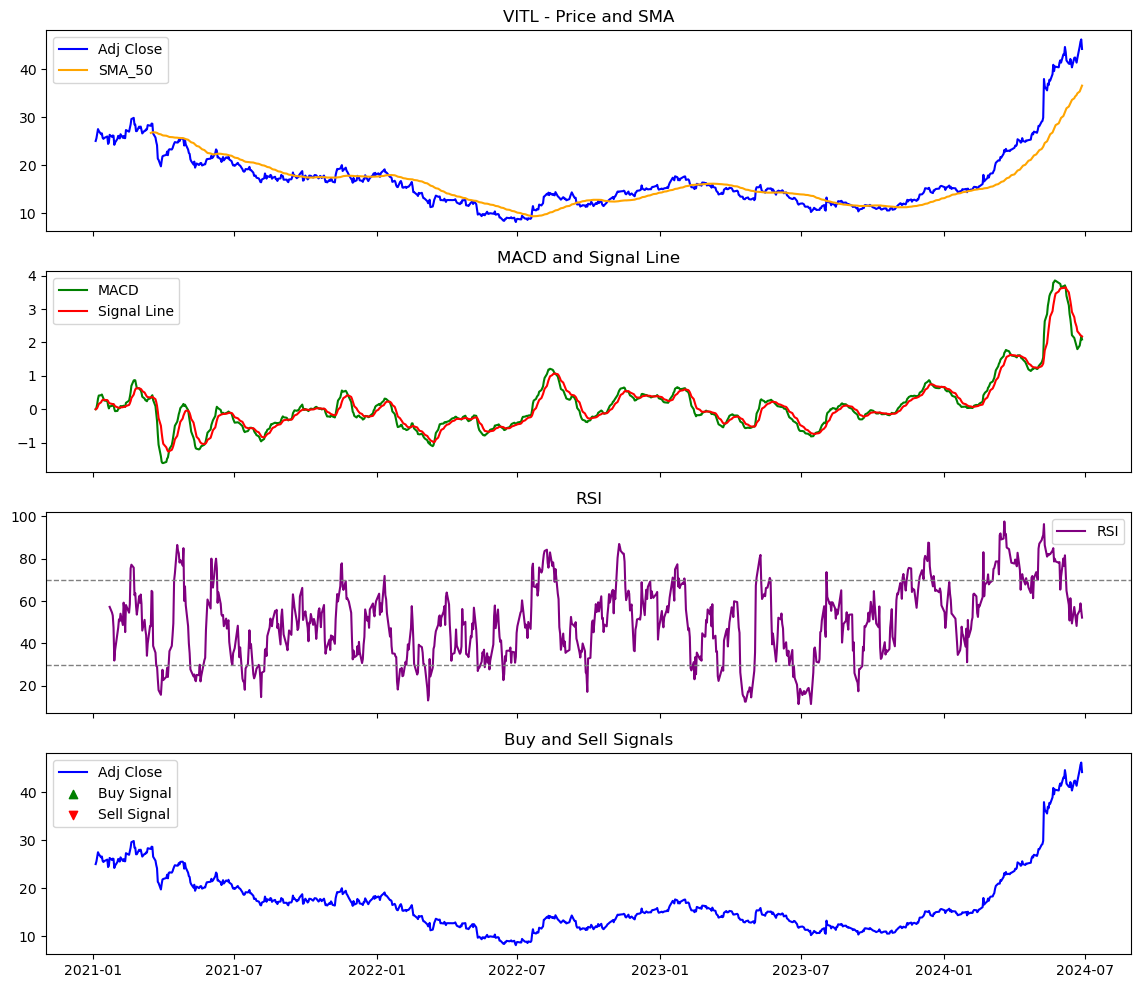

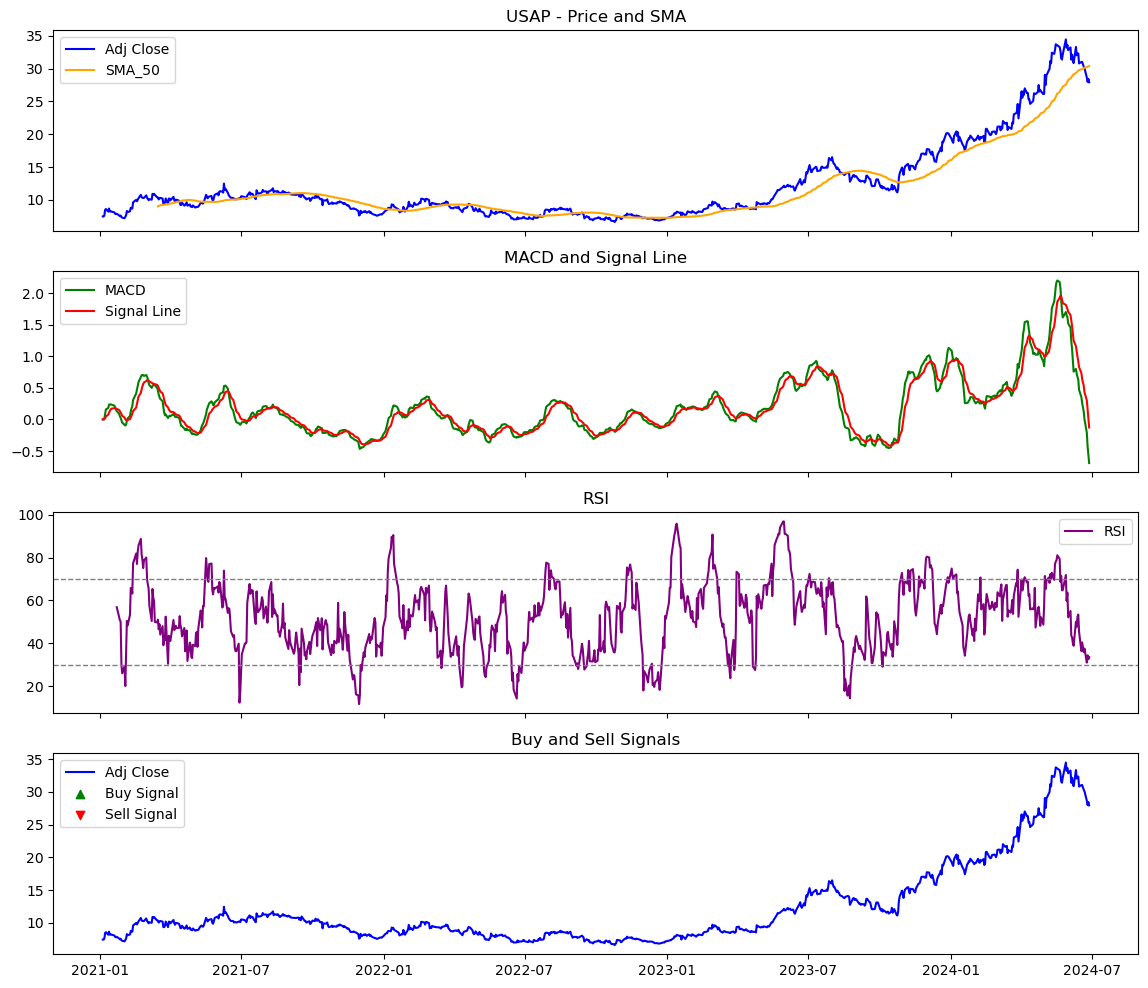

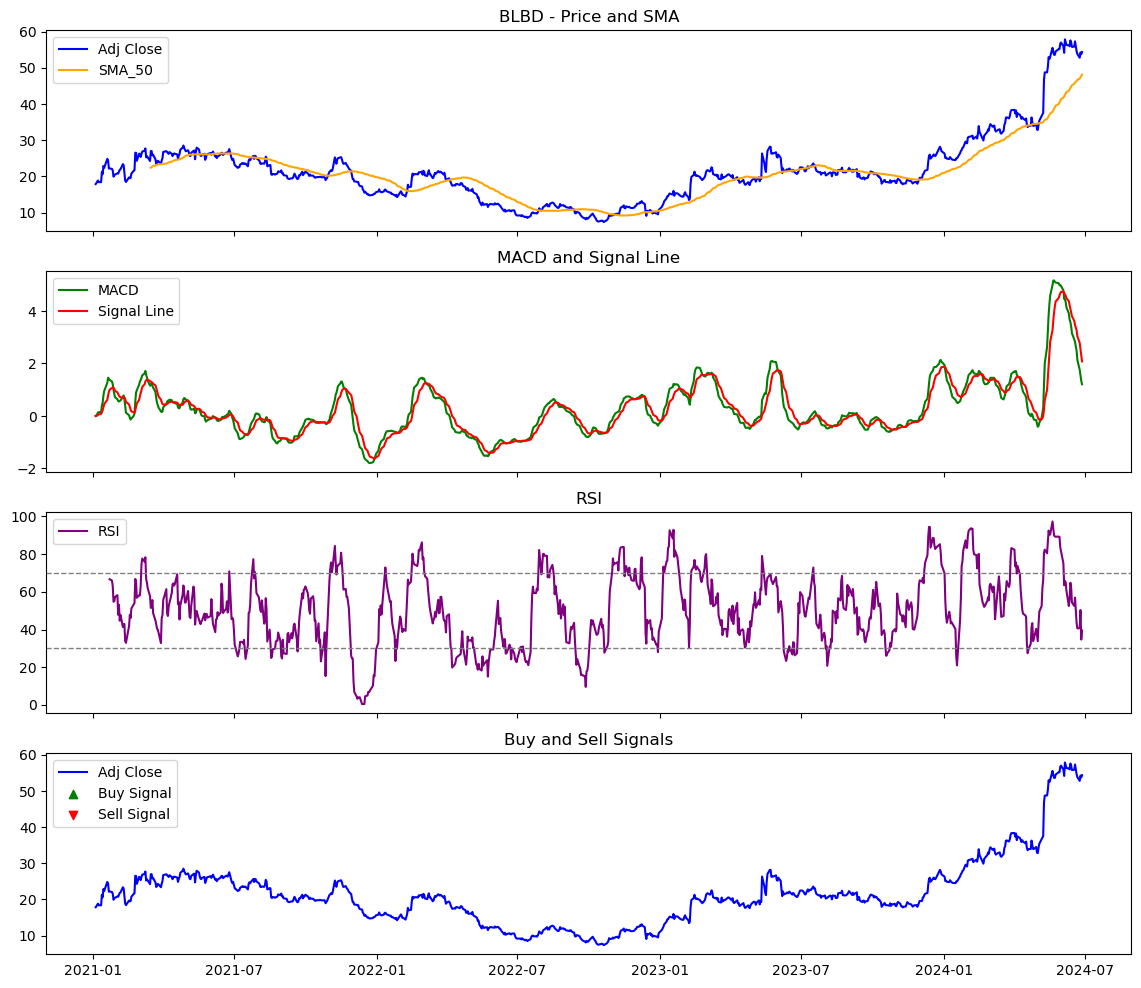

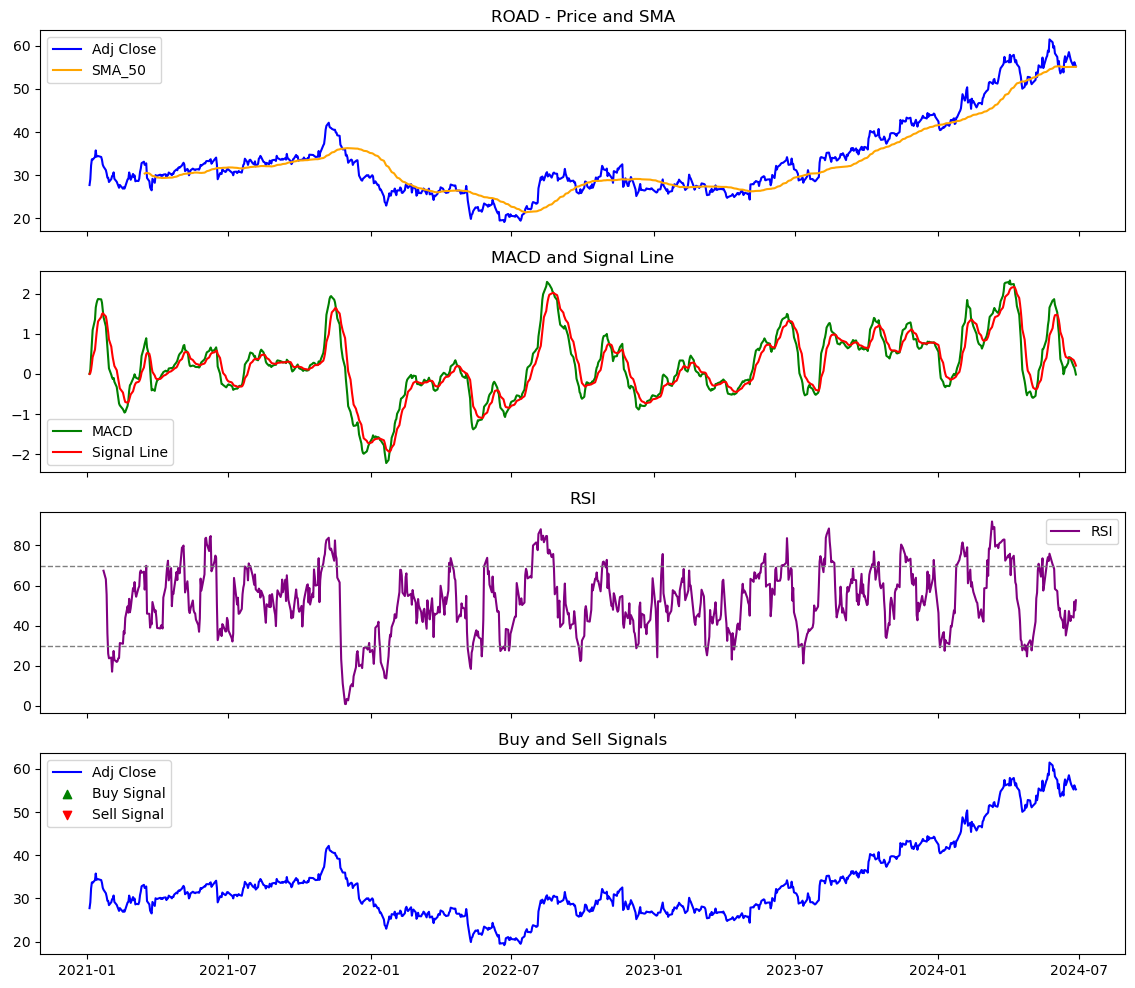

In [10]:
def plot_new_combined_indicators(data, title, sma_window=50):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
    
    ax1.plot(data['Adj Close'], label='Adj Close', color='blue')
    ax1.plot(data[f'SMA_{sma_window}'], label=f'SMA_{sma_window}', color='orange')
    ax1.set_title(f'{title} - Price and SMA')
    ax1.legend()
    
    ax2.plot(data['MACD'], label='MACD', color='green')
    ax2.plot(data['Signal Line'], label='Signal Line', color='red')
    ax2.set_title('MACD and Signal Line')
    ax2.legend()
    
    ax3.plot(data['RSI'], label='RSI', color='purple')
    ax3.axhline(30, linestyle='--', linewidth=1, color='grey')
    ax3.axhline(70, linestyle='--', linewidth=1, color='grey')
    ax3.set_title('RSI')
    ax3.legend()

    buy_signals = data[data['Signal'] == 1]
    sell_signals = data[data['Signal'] == -1]
    ax4.plot(data['Adj Close'], label='Adj Close', color='blue')
    ax4.legend()
    plt.show()

for stock, name in zip(stocks, stock_names):
    plot_new_combined_indicators(stock, name)